In [4]:
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
# !pip install lazypredict
from sklearn.model_selection import train_test_split
# import lazypredict
# from lazypredict.Supervised import LazyRegressor

In [5]:
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.linear_model import LassoCV ,RidgeCV , ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score

In [6]:
df=pd.read_csv('/content/Walmart (1).csv')

In [7]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [8]:
df.shape

(6435, 8)

In [9]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

no null values in any column - clean data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


date has object dtype which we would need to change to datetime dtype later.

In [11]:
df.describe().style.background_gradient(cmap='YlGnBu')

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1046964.877562,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,564366.622054,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,209986.250000,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,553350.105000,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,960746.040000,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1420158.660000,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3818686.450000,1.000000,100.140000,4.468000,227.232807,14.313000


###Fixing Datatype

In [12]:
df['Date']=pd.to_datetime(df['Date'])

###Checking for duplicates


In [13]:
df[df.duplicated()] #no duplicates

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


###Checking for Outliers

In [14]:
cols_num=df.select_dtypes(include=['int','float']).columns

#plotting boxplots
fig = make_subplots(rows=2, cols=4, shared_yaxes=False, horizontal_spacing=0.10 )
r=[1,1,1,1,2,2,2,2]
c=[1,2,3,4,1,2,3,4]
for i,z in zip(cols_num,range(0,7)):
  fig.add_trace(go.Box(y=df[i],name=i), row=r[z], col=c[z])

fig.show()


Now checking the count of the outliers

In [15]:
def find_outliers(df, col):
  IQR= df[col].quantile(0.75)-df[col].quantile(0.25)
  lower_bound= df[col].quantile(0.25)-1.5*IQR
  upper_bound= df[col].quantile(0.75)+1.5*IQR

  return df[(df[col]>upper_bound) | (df[col]<lower_bound)]

In [16]:
def count_outliers(df):
  df_num=df.select_dtypes(include=['int','float'])
  cols=df_num.columns

  outlier_cols=[x for x in cols if len(find_outliers(df_num, x))!=0]
  outlier_df=pd.DataFrame(columns=['outlier_count','outlier_percent'])

  for col in outlier_cols:
    out_count=len(find_outliers(df_num,col))
    out_percent= round((out_count*100)/len(df[col]), 2)

    outlier_df.loc[col]=[out_count, out_percent]

  return outlier_df

In [17]:
outliers=count_outliers(df).sort_values(by='outlier_count',ascending=False)
outliers

,outlier_count,outlier_percent
Unemployment,481.0,7.47
Holiday_Flag,450.0,6.99
Weekly_Sales,34.0,0.53
Temperature,3.0,0.05


In [18]:
find_outliers(df,'Unemployment')['Unemployment'].describe()

count    481.000000
mean      11.447480
std        3.891387
min        3.879000
25%       11.627000
50%       13.503000
75%       14.021000
max       14.313000
Name: Unemployment, dtype: float64

In [19]:
find_outliers(df,'Holiday_Flag')['Holiday_Flag'].describe()

count    450.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Holiday_Flag, dtype: float64

since there are not many holidays, 1(holiday) is considered as an outlier.

In [20]:
find_outliers(df,'Weekly_Sales').sample(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1813,13,2011-12-16,2760346.71,0,27.85,3.282,129.898065,6.392
474,4,2010-12-17,2740057.14,0,46.57,2.884,126.879484,7.127
1333,10,2010-12-24,3749057.69,0,57.06,3.236,126.983581,9.003
1761,13,2010-12-17,2771646.81,0,35.21,2.842,126.879484,7.795
526,4,2011-12-16,2771397.17,0,36.44,3.149,129.898065,5.143
2811,20,2011-11-25,2906233.25,1,46.38,3.492,211.412076,7.082
2814,20,2011-12-16,2762816.65,0,37.16,3.413,212.068504,7.082
1904,14,2010-12-17,2762861.41,0,30.51,3.140,182.517732,8.724
3192,23,2010-12-24,2734277.10,0,22.96,3.150,132.747742,5.287
2815,20,2011-12-23,3555371.03,0,40.19,3.389,212.236040,7.082


Most of the outliers in sales occur during months of Dec and Nov

In [21]:
find_outliers(df,'Temperature')['Temperature'].describe()

count    3.000000
mean     3.236667
std      4.600004
min     -2.060000
25%      1.740000
50%      5.540000
75%      5.885000
max      6.230000
Name: Temperature, dtype: float64

There are only 3 occurences of outliers in temp which is not that significant so we won't change it.

#Feature Engineering

extracting day , month , year and week out of Date column for time series analysis.

In [22]:
df['Day']= df['Date'].dt.weekday
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['Week']=df['Date'].dt.week


##Analysing Distribution


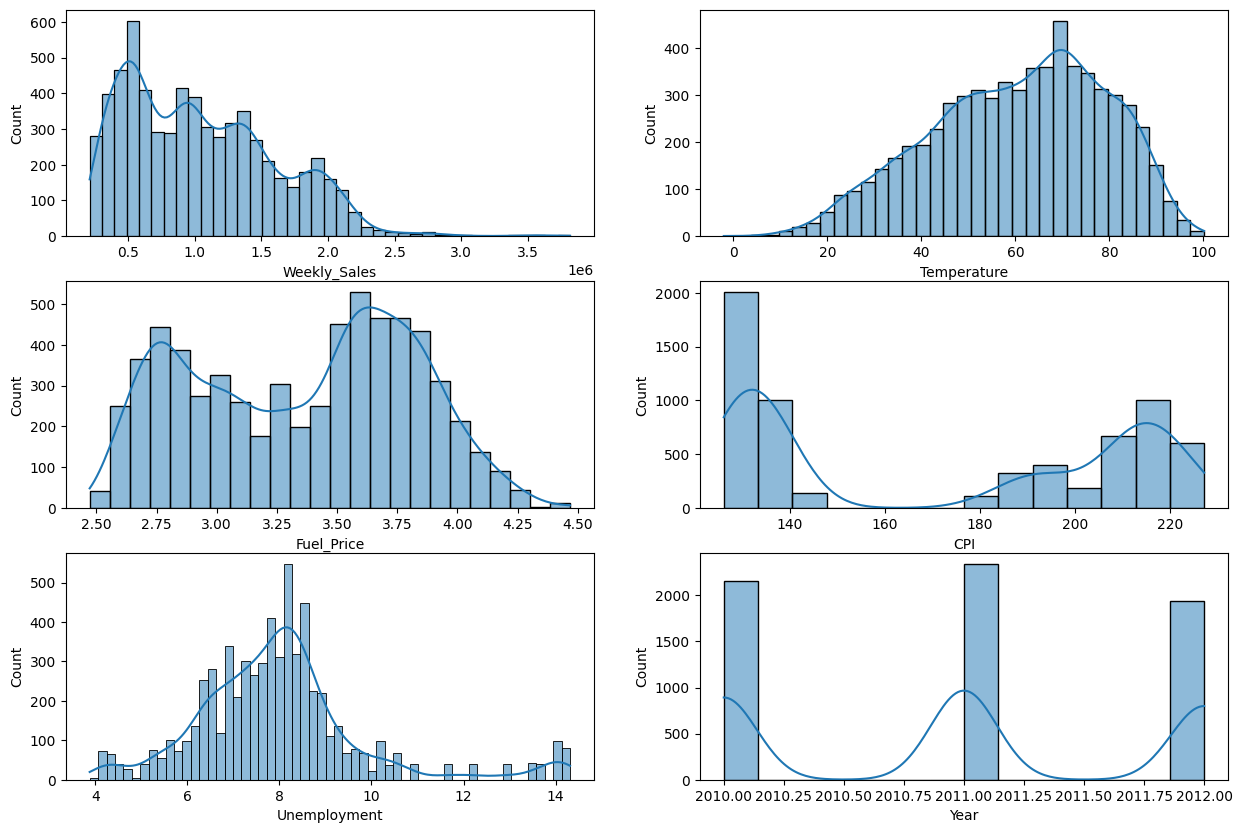

In [23]:
n = 1
plt.figure(figsize=(15,10))
for i in ['Weekly_Sales','Temperature', 'Fuel_Price','CPI', 'Unemployment','Year']:
        if n<=6:
            plt.subplot(3,2,n);
            n+=1
            sns.histplot(x = df[i],kde=True)
            plt.xlabel(i)



sales plotted over various time periods

In [24]:
month_wise_sales=df.groupby('Month')['Weekly_Sales'].sum()
week_wise_sales=df.groupby('Week')['Weekly_Sales'].sum()
day_wise_sales=df.groupby('Day')['Weekly_Sales'].sum()
year_wise_sales=df.groupby('Year')['Weekly_Sales'].sum()

In [25]:
list=[month_wise_sales,week_wise_sales,day_wise_sales,year_wise_sales]

In [26]:
for i in list:
  fig=px.bar(i,text_auto=True,color_discrete_sequence=px.colors.qualitative.Safe)
  fig.show()

In [27]:
fig=px.pie(year_wise_sales,values=year_wise_sales.values ,names=year_wise_sales.index,hole=0.3,color_discrete_sequence=px.colors.sequential.Blugrn)
fig.show()

In [28]:
holiday_sales=df.groupby('Holiday_Flag')['Weekly_Sales'].sum()
fig=px.pie(holiday_sales,values=holiday_sales.values ,names=holiday_sales.index,hole=0.3,color_discrete_sequence=px.colors.sequential.Emrld)
fig.show()


holidays share 7.5% of total sales

In [29]:
#Sales every month compared over three months
monthly_sales = pd.pivot_table(df, index = "Month", columns = "Year", values = "Weekly_Sales")

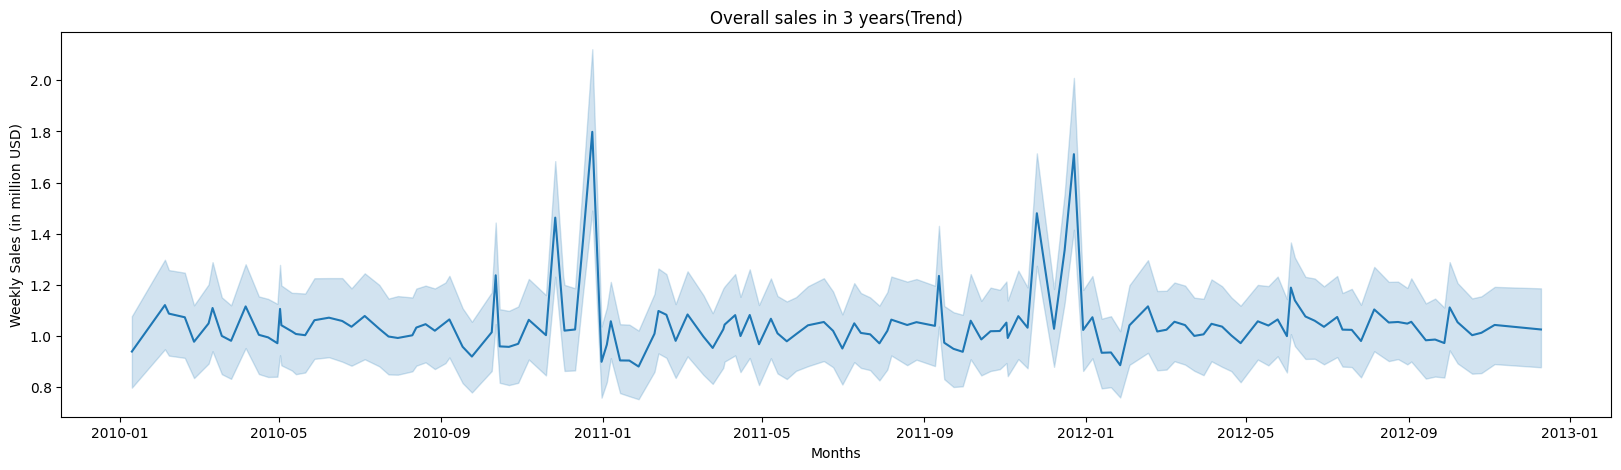

In [30]:
plt.figure(figsize=(20,5))

sns.lineplot(x=df.Date, y=(df.Weekly_Sales/1e6))

plt.xlabel('Months')
plt.ylabel('Weekly Sales (in million USD)')
plt.title('Overall sales in 3 years(Trend)')
plt.savefig('plot.png')
plt.show()


In [31]:
fig = px.line(monthly_sales ,title='Sales per month over 3 years(Seasonality)',color_discrete_sequence= px.colors.qualitative.Set2)
fig.show()

Sales shoot up during Nov and Dec.

Sales by Stores

In [32]:
sales_store = df.groupby('Store')['Weekly_Sales'].sum().reset_index()

In [33]:
sales_store.head()

,Store,Weekly_Sales
0,1,2.224028e+08
1,2,2.753824e+08
2,3,5.758674e+07
3,4,2.995440e+08
4,5,4.547569e+07


In [34]:
fig=px.bar(sales_store.sort_values(by='Weekly_Sales',ascending= False),x='Store',y='Weekly_Sales',title='Sales by Store',color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

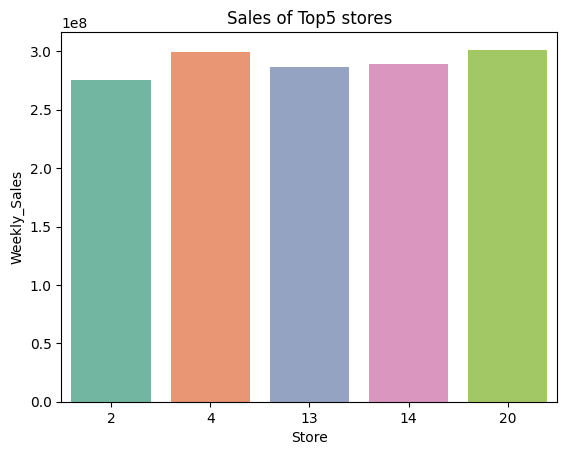

In [35]:

sns.barplot(x='Store',y='Weekly_Sales',data=sales_store.sort_values(by='Weekly_Sales',ascending= False).head(5),
            palette='Set2')
plt.title('Sales of Top5 stores')
plt.show()


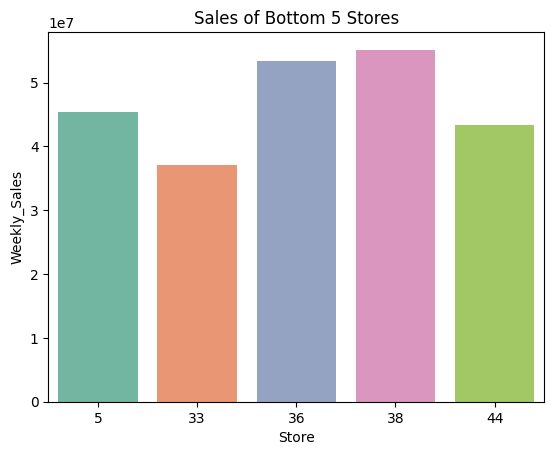

In [36]:
sns.barplot(x='Store',y='Weekly_Sales',data=sales_store.sort_values(by='Weekly_Sales',ascending= True).head(5),
            palette='Set2')
plt.title('Sales of Bottom 5 Stores')

plt.show()

Additionally, there is a strong seasonal component to the sales data. The average sales of the top performing stores are up to 500% higher than the lowest performing stores.

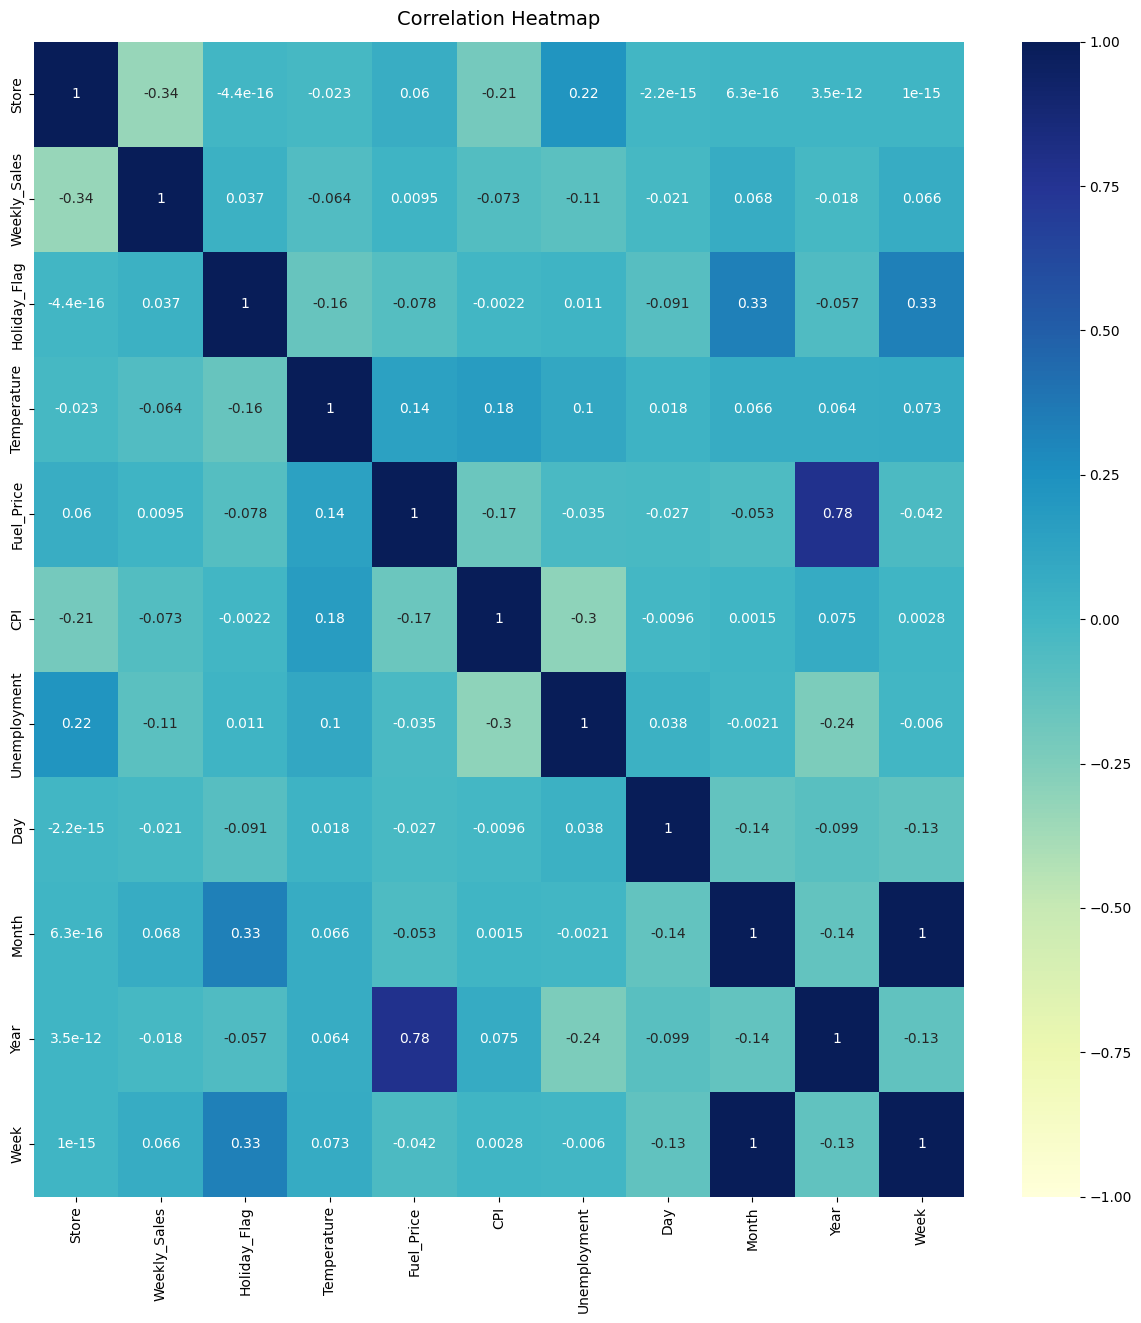

In [37]:
fig, ax = plt.subplots(figsize=(15,15))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap ="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.savefig('corr.png')

fuel price , CPI have very little to no correlation with weekly sales


#Model Building

##SARIMA

In [38]:
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.9 MB/s eta 0:00:00


In [39]:
df2=df.copy()
df2.set_index('Date',inplace=True)
df2.sort_index(inplace=True)
df2=df2[['Store','Weekly_Sales']]

In [40]:
store1=df2[df2['Store']==1].drop('Store',axis=1)
store1.head()

,Weekly_Sales
Date,
2010-01-10,1453329.50
2010-02-04,1594968.28
2010-02-07,1492418.14
2010-02-19,1611968.17
2010-02-26,1409727.59


In [41]:
#Downsampling the time series to month freq.
store1=store1.resample('M').sum()
store1.tail(10)

,Weekly_Sales
Date,
2012-03-31,8105620.92
2012-04-30,6296057.93
2012-05-31,4822132.39
2012-06-30,9918775.26
2012-07-31,6125859.84
2012-08-31,6371304.79
2012-09-30,6136045.35
2012-10-31,6396615.91
2012-11-30,1611096.05


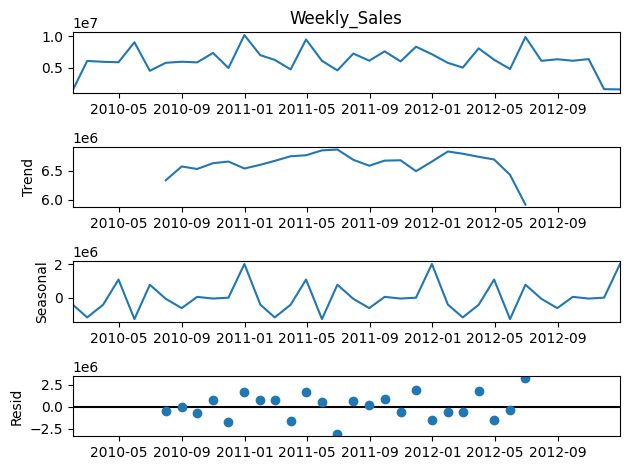

In [42]:
result= seasonal_decompose(store1['Weekly_Sales'],model='additive',period=12)
result.plot()
plt.savefig('decompose.png')


there's clearly seasonality 

In [43]:
#fitting auto-arima model
stepwise_fit= auto_arima(y=store1['Weekly_Sales'],start_p=1,start_q=1,max_p=3,max_q=3,
                         m=12,start_P=0,seasonal=True,D=1,trace=True,error_action='ignore',
                         suppress_warnings=True,stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=792.592, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=788.046, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=791.261, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=791.358, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=788.433, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=789.972, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=789.950, Time=0.05 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=791.813, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=789.541, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=789.540, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=791.339, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.061 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -392.023
Date:                  Sat, 03 Jun 2023   AIC                            788.046
Time:                          11:19:46   BIC                            790.402
Sample:                      01-31-2010   HQIC                           788.671
                           - 12-31-2012                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.115e+05   6.13e+05     -0.345      0.730   -1.41e+06     9.9e+05
sigma2      9.022e+12   2.73e+12      3.306      0.001    3.67e+12    1.44e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.69   Prob(JB):                         0.98
Heteroskedasticity (H):               1.79   Skew:                             0.01
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

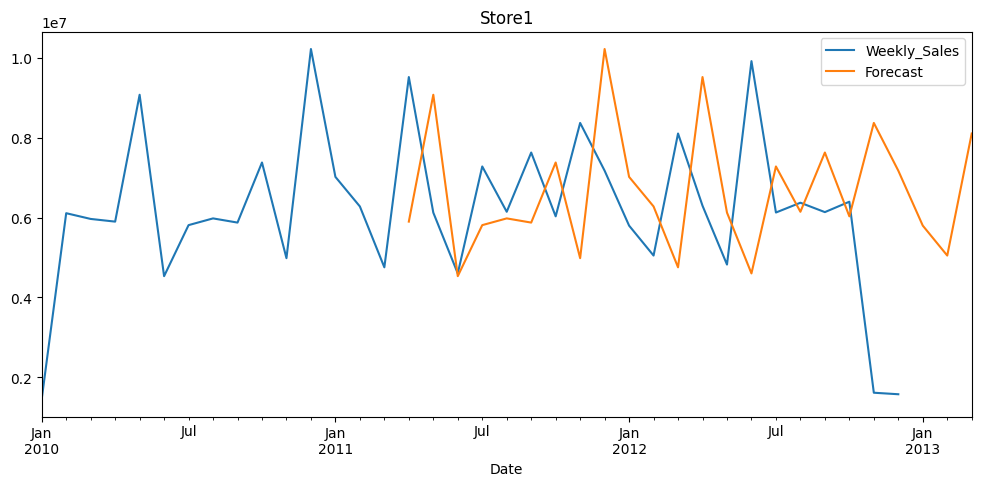

In [44]:
model=SARIMAX(store1['Weekly_Sales'],order=(0,0,0),seasonal_order=(0, 1, 0, 12))
result=model.fit()
result.summary()

forecast = result.predict(start = len(store1)-57, 
                          end = (len(store1)-1) + 3, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
plt.title('Store1')
store1['Weekly_Sales'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)
plt.savefig('store1.png')

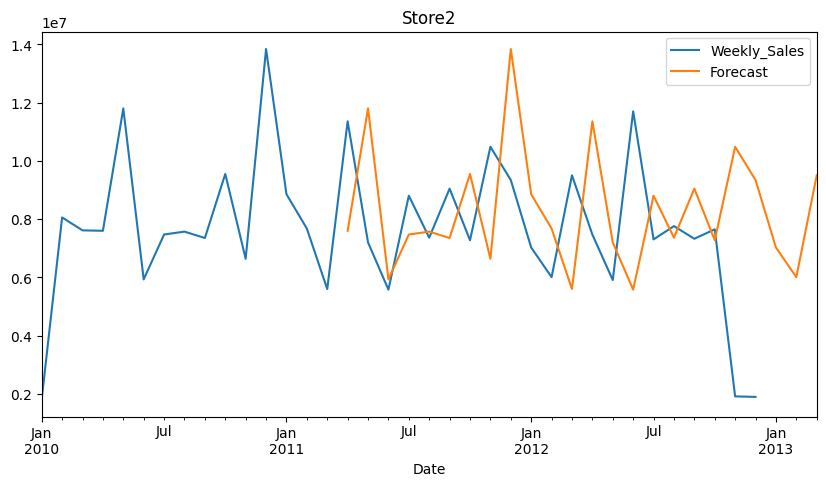

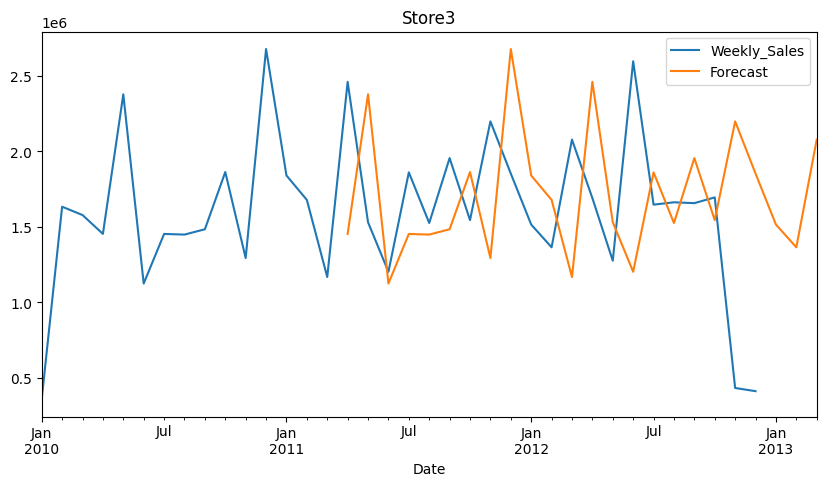

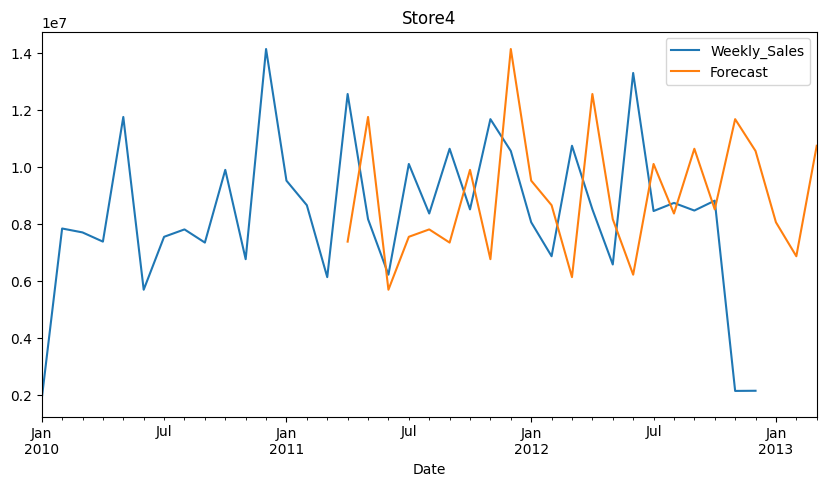

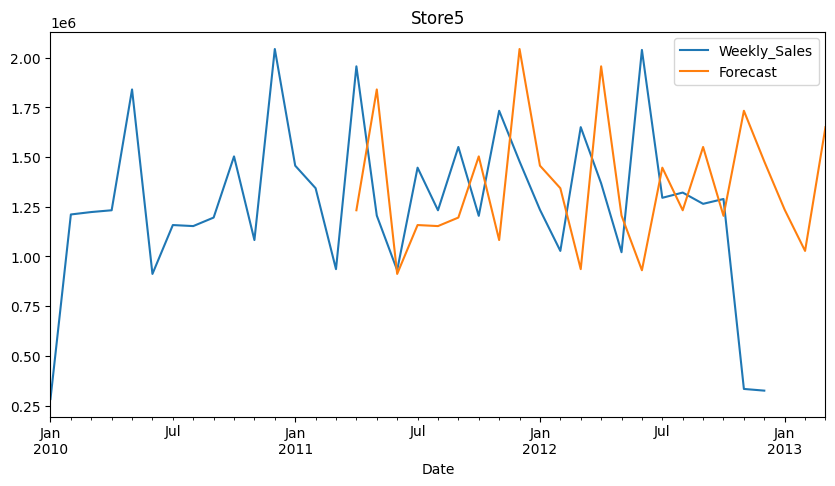

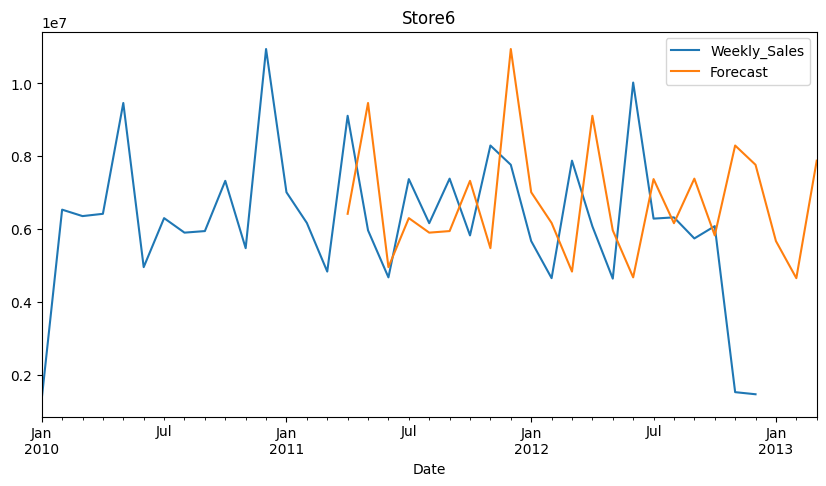

In [55]:
for i in range(2,46):
  store1=df2[df2['Store']==i].drop('Store',axis=1)
  store1=store1.resample('M').sum()

  model=SARIMAX(store1['Weekly_Sales'],order=(0,0,0),seasonal_order=(0, 1, 0, 12))
  result=model.fit()
  result.summary()

  forecast = result.predict(start = len(store1)-57, 
                          end = (len(store1)-1) + 3, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
  plt.figure(figsize=(10,5))
  plt.title(f'Store{i}')
  store1['Weekly_Sales'].plot(legend = True)
  forecast.plot(legend = True)
  #plt.savefig(f'dwnldgraph{i}.png') uncomment to download graphs
  plt.show()




#Regression Models

In [56]:
df3=df.copy()
df3.drop("Date",axis=1,inplace=True)

In [57]:
x=df3.drop('Weekly_Sales',axis=1)
y=df3['Weekly_Sales']

std=StandardScaler()
x_scaled=std.fit_transform(x)

x_train, x_test, y_train, y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=1)

In [58]:
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.linear_model import LassoCV ,RidgeCV , ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import cross_val_score

In [59]:
def model(x_train,y_train,x_test,y_test,model):
  model1=model()
  model1.fit(x_train,y_train)
  y_pred=model1.predict(x_test)
  print('--------------------------')
  print(model1)
  print('--------------------------')
  print(f'R2score - {round(r2_score(y_test,y_pred)*100,2) }%')
  print(f'MSE - {mean_absolute_error(y_test,y_pred)}')
  print(f'MAE - {mean_squared_error(y_test,y_pred)}')


In [60]:
x=[model(x_train,y_train,x_test,y_test,i) for i in 
 [LinearRegression,Lasso,Ridge,ElasticNet,
  RandomForestRegressor,DecisionTreeRegressor,
  KNeighborsRegressor,GradientBoostingRegressor]]
x

--------------------------
LinearRegression()
--------------------------
R2score - 14.27%
MSE - 439470.2127544763
MAE - 283214599188.3492
--------------------------
Lasso()
--------------------------
R2score - 14.27%
MSE - 439467.91395826376
MAE - 283213208030.0946
--------------------------
Ridge()
--------------------------
R2score - 14.28%
MSE - 439435.00090235414
MAE - 283191691085.85645
--------------------------
ElasticNet()
--------------------------
R2score - 12.46%
MSE - 447231.32016065216
MAE - 289185579417.19714
--------------------------
RandomForestRegressor()
--------------------------
R2score - 95.8%
MSE - 63244.0239268065
MAE - 13875647035.024096
--------------------------
DecisionTreeRegressor()
--------------------------
R2score - 91.69%
MSE - 82315.95133644134
MAE - 27443897014.20318
--------------------------
KNeighborsRegressor()
--------------------------
R2score - 31.51%
MSE - 352744.0643480963
MAE - 226279877308.3822
--------------------------
GradientBoostingRe

[None, None, None, None, None, None, None, None]

Random Forest Regressor seems to perform the best.